In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloudb

In [2]:
import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout, LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [5]:
fake=pd.read_csv('https://raw.githubusercontent.com/shinjondas/fake-news-detection/main/data/Fake.csv')

In [6]:
true=pd.read_csv('https://raw.githubusercontent.com/shinjondas/fake-news-detection/main/data/True.csv')

In [7]:
fake.head()

title  ...               date
0   Donald Trump Sends Out Embarrassing New Year’...  ...  December 31, 2017
1   Drunk Bragging Trump Staffer Started Russian ...  ...  December 31, 2017
2   Sheriff David Clarke Becomes An Internet Joke...  ...  December 30, 2017
3   Trump Is So Obsessed He Even Has Obama’s Name...  ...  December 29, 2017
4   Pope Francis Just Called Out Donald Trump Dur...  ...  December 25, 2017

[5 rows x 4 columns]

In [34]:
fake.text

0        Donald Trump just couldn t wish all Americans ...
1        House Intelligence Committee Chairman Devin Nu...
2        On Friday, it was revealed that former Milwauk...
3        On Christmas day, Donald Trump announced that ...
4        Pope Francis used his annual Christmas Day mes...
                               ...                        
23476    21st Century Wire says As 21WIRE reported earl...
23477    21st Century Wire says It s a familiar theme. ...
23478    Patrick Henningsen  21st Century WireRemember ...
23479    21st Century Wire says Al Jazeera America will...
23480    21st Century Wire says As 21WIRE predicted in ...
Name: text, Length: 23481, dtype: object

In [8]:
true.head()

title  ...                date
0  As U.S. budget fight looms, Republicans flip t...  ...  December 31, 2017 
1  U.S. military to accept transgender recruits o...  ...  December 29, 2017 
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...  December 31, 2017 
3  FBI Russia probe helped by Australian diplomat...  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much mor...  ...  December 29, 2017 

[5 rows x 4 columns]

In [9]:
text_fake=' '.join(fake['text'].tolist())

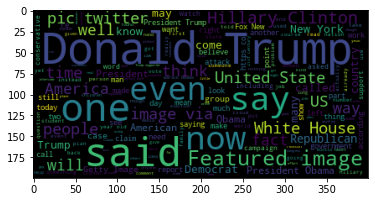

In [10]:
wordcloud=WordCloud().generate(text_fake)
plt.imshow(wordcloud)

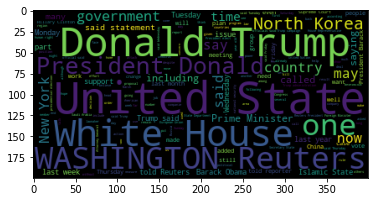

In [11]:
text_true=' '.join(true['text'].tolist())
wordcloud=WordCloud().generate(text_true)
plt.imshow(wordcloud)

In [25]:
unknown_publishers=[]
for index,row in enumerate(true.text.values):
  try:
    record=row.split('-',maxsplit=1)
    record[1]
    assert(len(record[0])<120)
  except:
    unknown_publishers.append(index)

In [26]:
len(unknown_publishers)

221

In [27]:
true.iloc[unknown_publishers].text

7        The following statements were posted to the ve...
8        The following statements were posted to the ve...
12       The following statements were posted to the ve...
13       The following statements were posted to the ve...
14        (In Dec. 25 story, in second paragraph, corre...
                               ...                        
20135     (Story corrects to million from billion in pa...
20500     (This Sept 8 story corrects headline, clarifi...
20667     (Story refiles to add dropped word  not , in ...
21246     (Story corrects third paragraph to show Mosul...
21339     (Story corrects to fix spelling in paragraph ...
Name: text, Length: 221, dtype: object

In [28]:
publisher=[]
tmp_text=[]
for index,row in enumerate(true.text.values):
  if index in unknown_publishers:
    tmp_text.append(row)
    publisher.append('Unknown')
  else:
    record=row.split('-',maxsplit=1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [29]:
true['publisher']=publisher
true['text']=tmp_text

In [30]:
true.head()

title  ...                     publisher
0  As U.S. budget fight looms, Republicans flip t...  ...          WASHINGTON (Reuters)
1  U.S. military to accept transgender recruits o...  ...          WASHINGTON (Reuters)
2  Senior U.S. Republican senator: 'Let Mr. Muell...  ...          WASHINGTON (Reuters)
3  FBI Russia probe helped by Australian diplomat...  ...          WASHINGTON (Reuters)
4  Trump wants Postal Service to charge 'much mor...  ...  SEATTLE/WASHINGTON (Reuters)

[5 rows x 5 columns]

In [36]:
empty_fake_index=[index for index,text in enumerate(fake.text.tolist()) if str(text).strip()==""]

In [37]:
fake.iloc[empty_fake_index]

title  ...          date
10923  TAKE OUR POLL: Who Do You Think President Trum...  ...  May 10, 2017
11041  Joe Scarborough BERATES Mika Brzezinski Over “...  ...  Apr 26, 2017
11190  WATCH TUCKER CARLSON Scorch Sanctuary City May...  ...   Apr 6, 2017
11225  MAYOR OF SANCTUARY CITY: Trump Trying To Make ...  ...   Apr 2, 2017
11236  SHOCKER: Public School Turns Computer Lab Into...  ...   Apr 1, 2017
...                                                  ...  ...           ...
21816  BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...  ...  Apr 27, 2015
21826  FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...  ...  Apr 25, 2015
21827  (VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...  ...  Apr 25, 2015
21857  (VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...  ...  Apr 14, 2015
21873  (VIDEO) HYSTERICAL SNL TAKE ON HILLARY’S ANNOU...  ...  Apr 12, 2015

[630 rows x 4 columns]

In [38]:
true['text']=true['title']+true['text']
fake['text']=fake['title']+fake['text']

In [41]:
true['text']=true['text'].apply(lambda x:str(x).lower())
fake['text']=fake['text'].apply(lambda x:str(x).lower())

In [42]:
true['class']=1
fake['class']=0

In [43]:
true=true[['text','class']]

In [44]:
fake=fake[['text','class']]

In [47]:
data=true.append(fake,ignore_index=True)

In [48]:
data.head()

text  class
0  as u.s. budget fight looms, republicans flip t...      1
1  u.s. military to accept transgender recruits o...      1
2  senior u.s. republican senator: 'let mr. muell...      1
3  fbi russia probe helped by australian diplomat...      1
4  trump wants postal service to charge 'much mor...      1

In [49]:
import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [50]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [51]:
import gensim

In [52]:
y=data['class'].values

In [54]:
X=[d.split() for d in data['text'].tolist()]

In [56]:
DIM=100
w2v_model=gensim.models.Word2Vec(sentences=X,size=DIM,window=10,min_count=1)

In [57]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(X)

In [58]:
X=tokenizer.texts_to_sequences(X)

In [59]:
maxlen=1000
X=pad_sequences(X,maxlen=maxlen)

In [61]:
vocab_size=len(tokenizer.word_index)+1
vocab=tokenizer.word_index

In [64]:
def get_weight_matrix(model):
  weight_matrix=np.zeros((vocab_size,DIM))
  for word,i in vocab.items():
    weight_matrix[i]=model.wv[word]
  return weight_matrix

In [66]:
embedding_vectors=get_weight_matrix(w2v_model)

In [67]:
embedding_vectors.shape

(273392, 100)

In [68]:
model=Sequential()
model.add(Embedding(vocab_size,output_dim=DIM,weights=[embedding_vectors],input_length=maxlen,trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

In [69]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         27339200  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 27,456,577
Trainable params: 117,377
Non-trainable params: 27,339,200
_________________________________________________________________


In [70]:
X_train,X_test,y_train,y_test=train_test_split(X,y)

In [71]:
model.fit(X_train,y_train,validation_split=0.3,epochs=5)

Epoch 1/5
737/737 [==============================] - 134s 174ms/step - loss: 0.1395 - acc: 0.9489 - val_loss: 0.0966 - val_acc: 0.9651
Epoch 2/5
737/737 [==============================] - 122s 165ms/step - loss: 0.0670 - acc: 0.9770 - val_loss: 0.0538 - val_acc: 0.9829
Epoch 3/5
737/737 [==============================] - 122s 166ms/step - loss: 0.0293 - acc: 0.9907 - val_loss: 0.0251 - val_acc: 0.9920
Epoch 4/5
737/737 [==============================] - 122s 166ms/step - loss: 0.0155 - acc: 0.9954 - val_loss: 0.0257 - val_acc: 0.9916
Epoch 5/5
737/737 [==============================] - 122s 166ms/step - loss: 0.0120 - acc: 0.9959 - val_loss: 0.0235 - val_acc: 0.9934


In [76]:
y_predict=(model.predict(X_test)>=0.5).astype(int)

In [77]:
accuracy_score(y_predict,y_test)

0.9926057906458797